In [62]:
import os
import re
import json
import pandas as pd
import numpy as np
import requests
import itertools
import math
from tqdm import tqdm
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point
from matplotlib.ticker import FormatStrFormatter

plt.rcParams.update({'font.size':20})
plt.rcParams['figure.dpi'] = 300

In [84]:
df_districts = gpd.read_file('districtes.geojson')
df_barris = gpd.read_file('../gran-barri.geojson')

## Flickr Dataset

### Add district and neighborhood information exploiting geojson data.

In [ ]:
df = pd.read_csv('data/bcn/flickr_raw.csv')
df

In [ ]:
df['district'] = ""
df['neighborhood'] = ""

with tqdm(total=df.shape[0]) as pbar: 
    for index, row in df.iterrows():
        lat = row.lat
        long = row.long
        point = Point(long, lat)

        for district in range(0,len(df_districts)):
            polygon = shape(df_districts['geometry'][district])
            if polygon.contains(point):
                df.loc[index, 'district'] = df_districts['NOM'][district]

        for neighborhood in range(0,len(df_barris)):
            polygon = shape(df_barris['geometry'][neighborhood])
            if polygon.contains(point):
                df.loc[index, 'neighborhood'] = df_barris['NOM'][neighborhood]
        pbar.update(1)

In [ ]:
df = df.drop(['Unnamed: 0', 'tag'], axis=1).reset_index().drop('index', axis=1)
df

In [ ]:
df = df[df['district']!=""]
df = df[df['neighborhood']!=""]

In [ ]:
df = df.drop_duplicates(subset=['url']).reset_index().drop('index', axis=1)

In [ ]:
df

In [ ]:
df = df.to_csv('flickr.csv', index=False)

### Load data to generate plots

In [85]:
df = pd.read_csv('flickr.csv')
df

,url,lat,long,district,neighborhood
0,https://live.staticflickr.com/8790/28308123815...,41.384271,2.176183,Ciutat Vella,el Barri Gòtic\r\n
1,https://live.staticflickr.com/65535/4977197167...,41.375805,2.177964,Ciutat Vella,el Barri Gòtic\r\n
2,https://live.staticflickr.com/3002/2814274154_...,41.400360,2.180914,Eixample,el Fort Pienc
3,https://live.staticflickr.com/2680/4324456481_...,41.400360,2.180914,Eixample,el Fort Pienc
4,https://live.staticflickr.com/4835/45333422864...,41.386025,2.172900,Ciutat Vella,el Barri Gòtic\r\n
...,...,...,...,...,...
17934,https://live.staticflickr.com/4764/39843837144...,41.415638,2.193158,Sant Andreu,"la Sagrera, el Congrés i Navas\r\n\r\n\r\n"
17935,https://live.staticflickr.com/1756/40866540930...,41.389141,2.193703,Sant Martí,"el Parc, la Llacuna i la Vila Olímpica\r\n\r\n"
17936,https://live.staticflickr.com/65535/4911612506...,41.405166,2.184772,Sant Martí,el Clot i el Camp de l'Arpa\r\n\r\n
17937,https://live.staticflickr.com/65535/4931242327...,41.404072,2.183844,Eixample,la Sagrada Família


In [86]:
n_images = df['district'].value_counts().rename_axis('NOM').reset_index(name='counts')

In [87]:
df_districts = df_districts.merge(n_images, on='NOM', how='left')
df_districts['counts'] = df_districts['counts'].fillna(0)

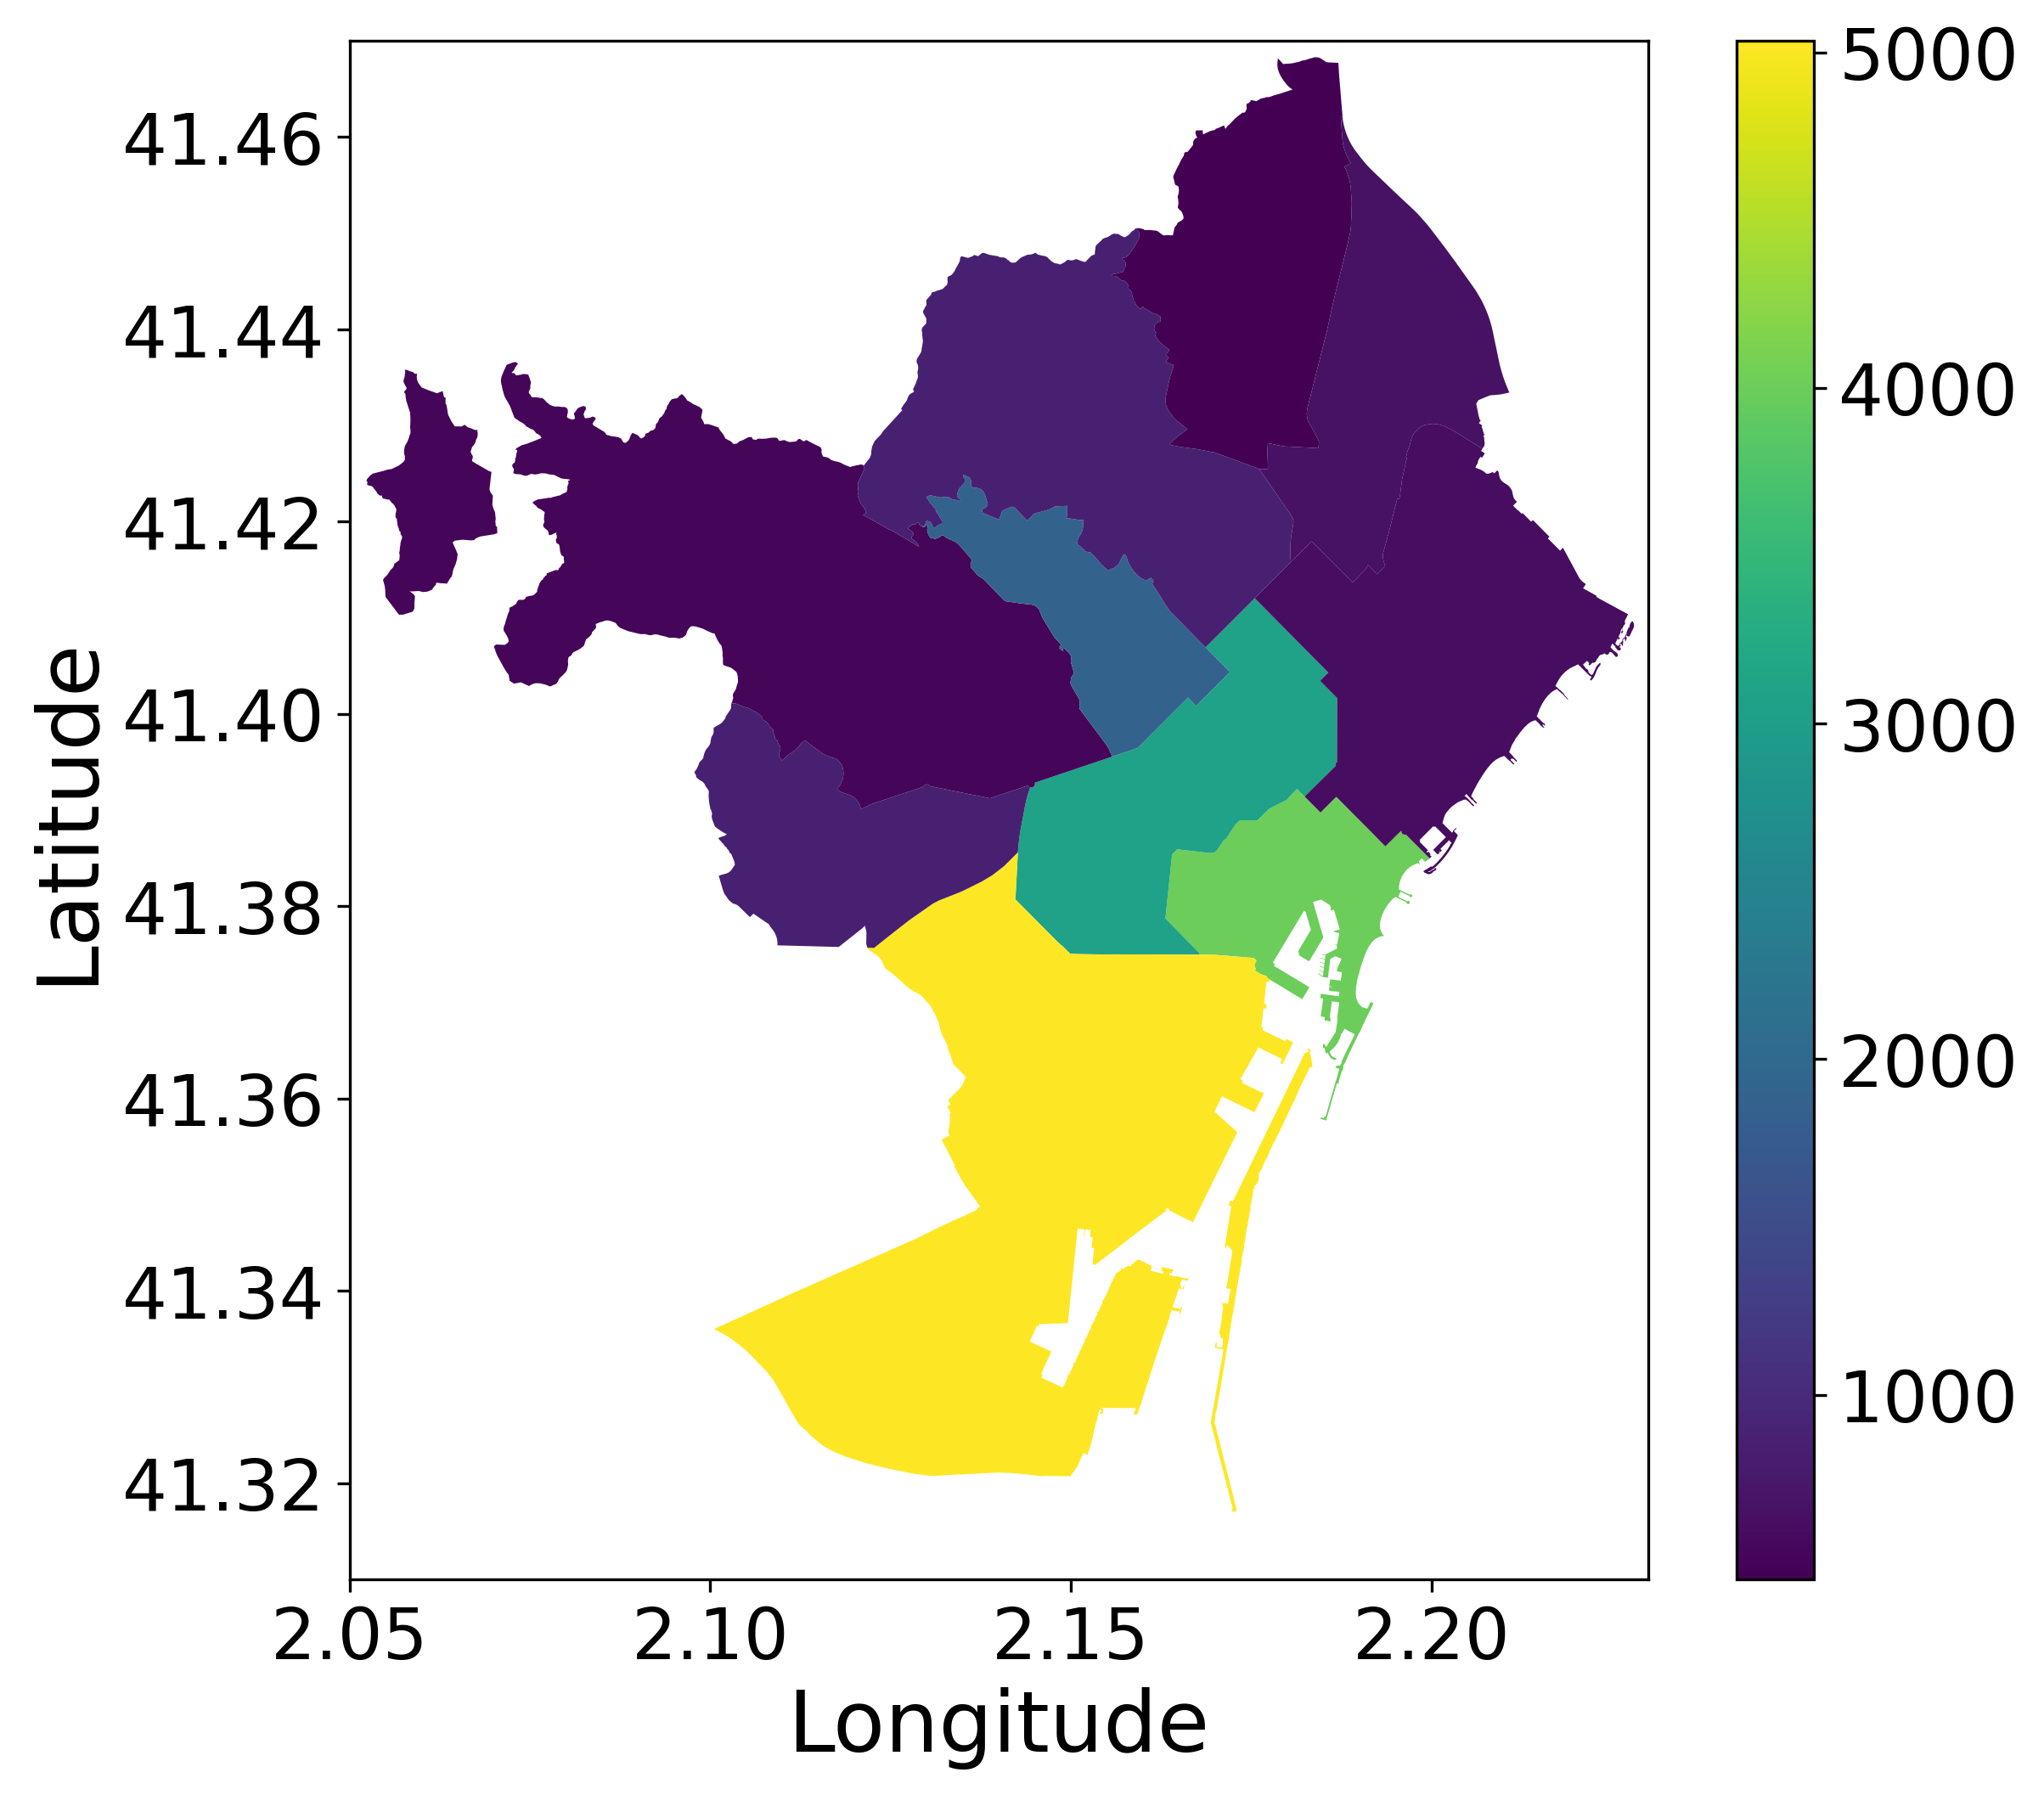

In [91]:
#plt.rcParams.update({'font.size':20})
#plt.rcParams['figure.dpi'] = 300
fig = df_districts.plot(column='counts', legend=True, figsize=(9,8))
plt.ylabel('Latitude', fontsize=24)
plt.xlabel('Longitude', fontsize=24)
plt.xlim(2.05,2.23)
plt.ylim(41.31,41.47)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#plt.show()
plt.savefig('img/flickr_districts.png')

In [ ]:
df_districts['geometry'].plot()
plt.rcParams['figure.dpi'] = 300
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.scatter(df['long'], df['lat'], alpha=0.5, s=2, c='red')

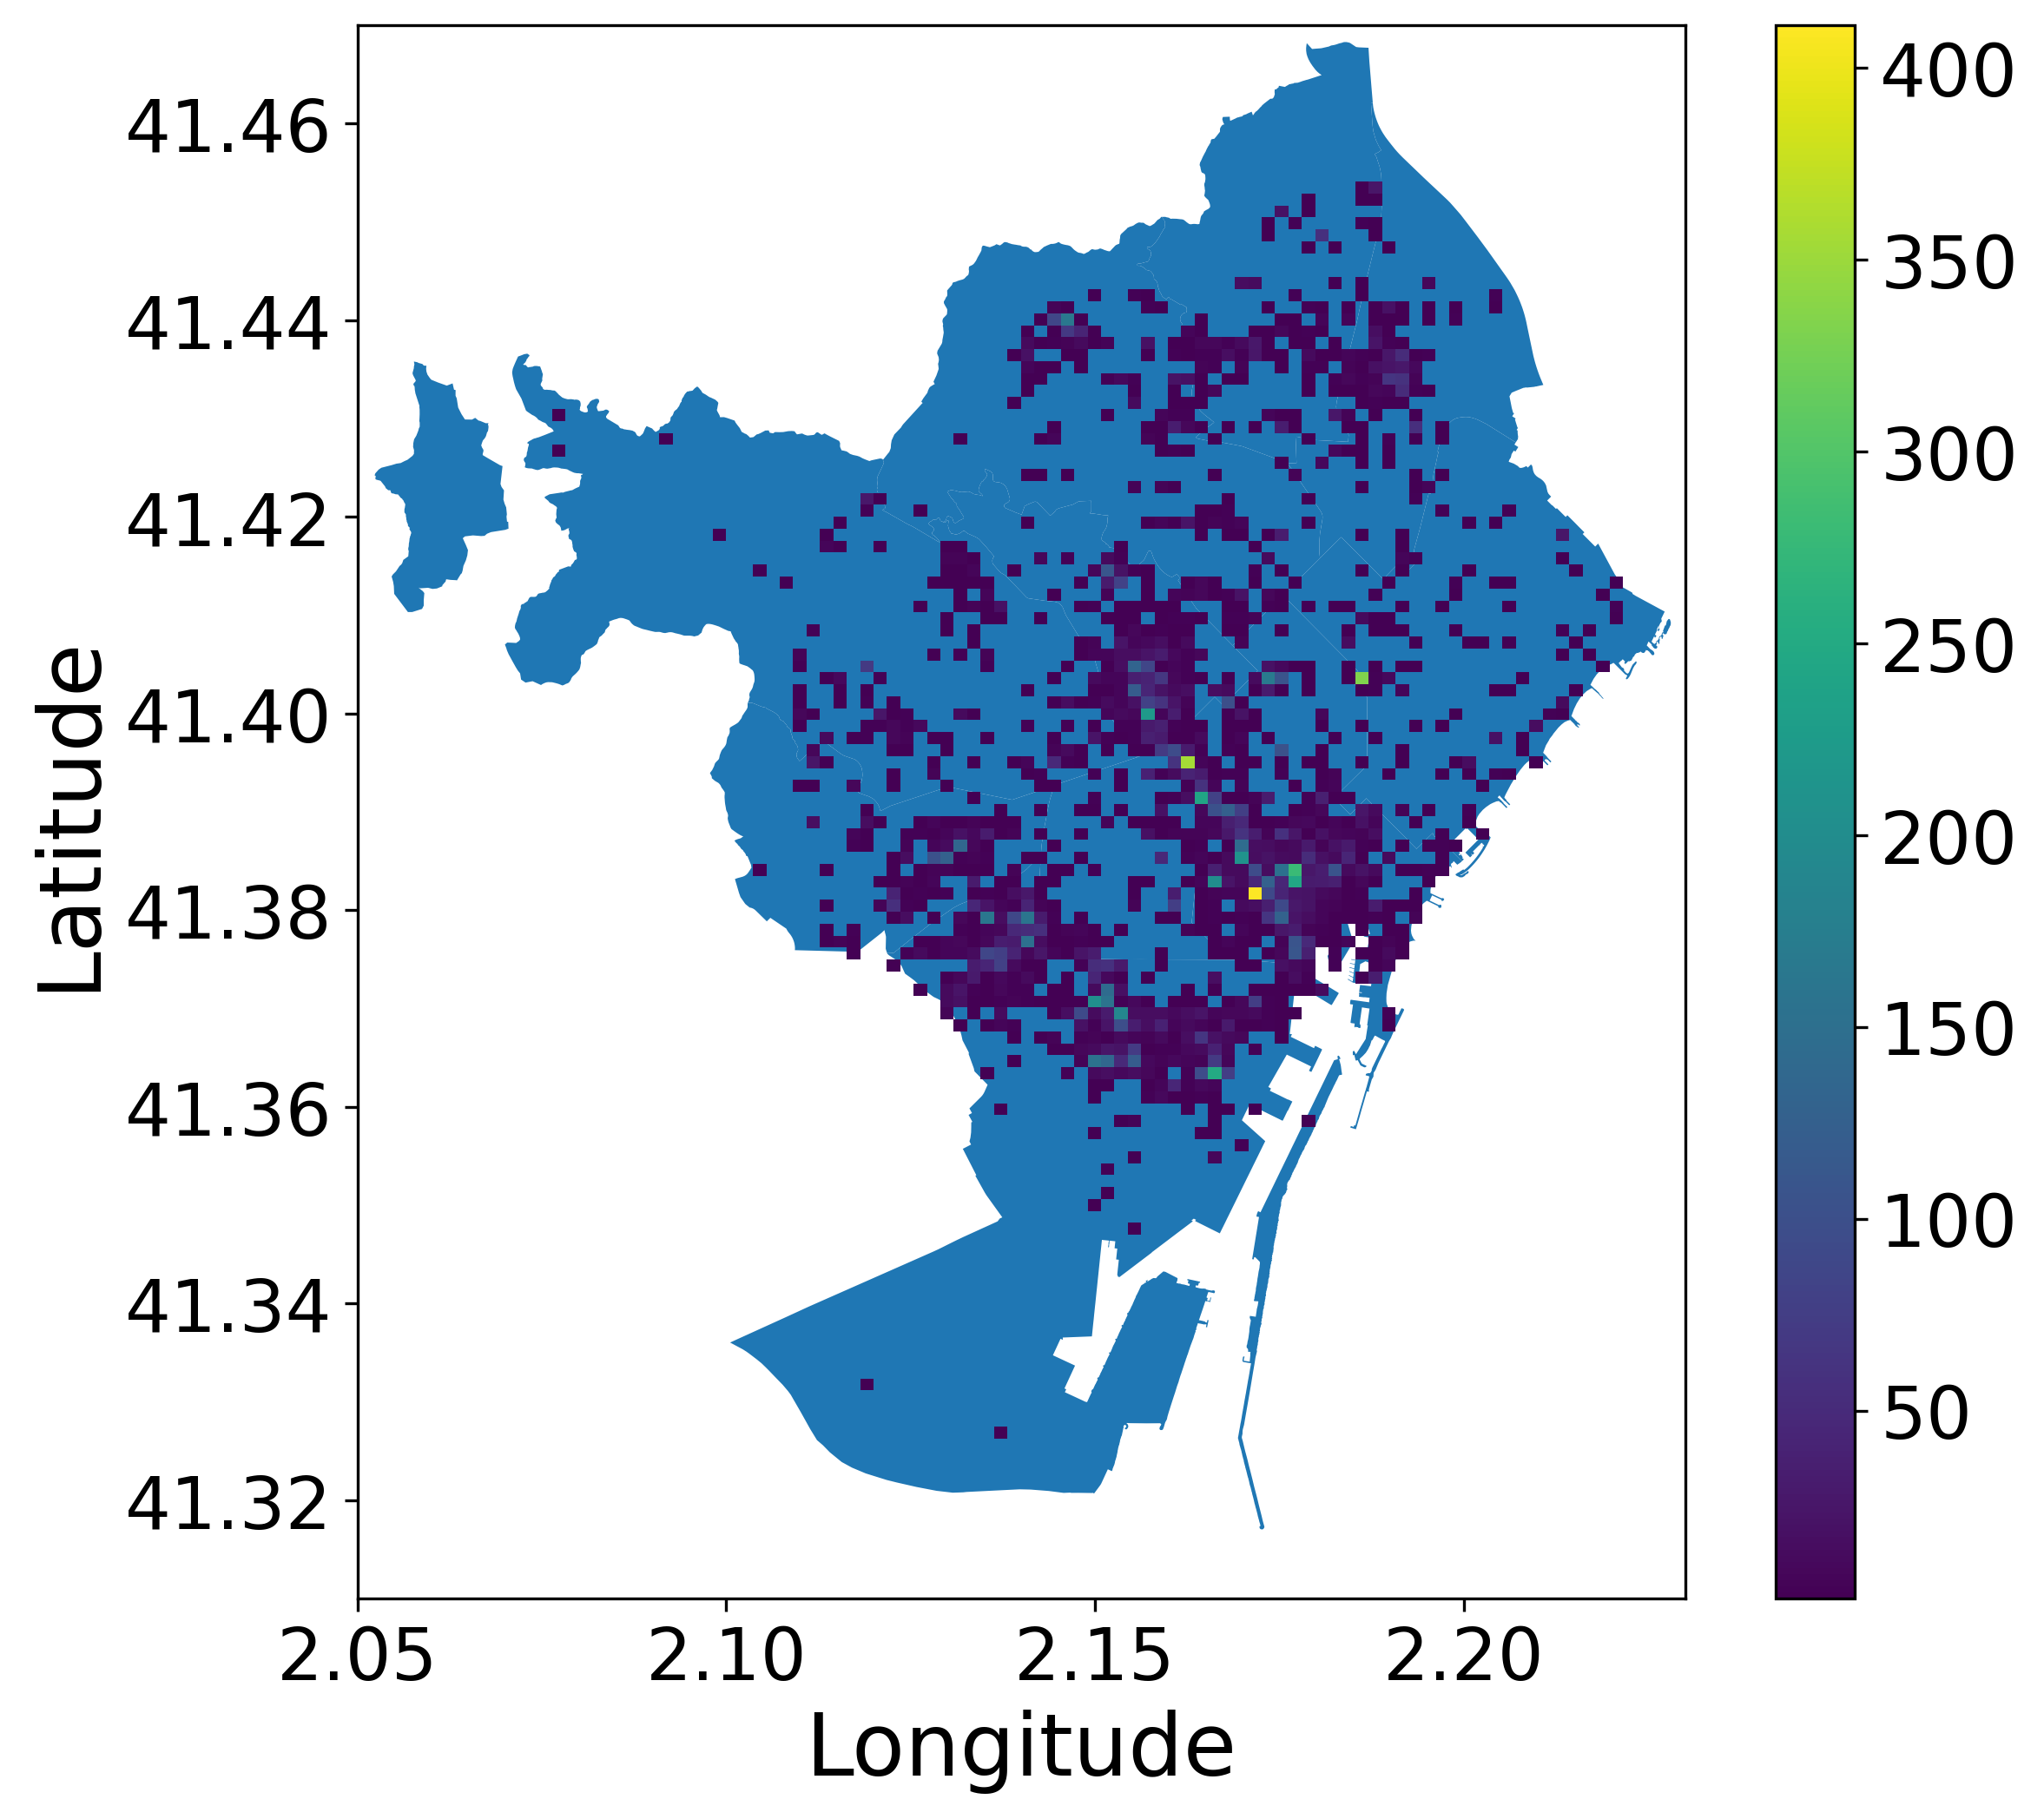

In [93]:
fig = df_districts['geometry'].plot(figsize=(9,8))
plt.hist2d(df['long'],df['lat'], bins=(80,105), cmin=1)#, cmap='viridis')
plt.colorbar()
plt.ylabel('Latitude', fontsize=24)
plt.xlabel('Longitude', fontsize=24)
plt.xlim(2.05,2.23)
plt.ylim(41.31,41.47)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.show()
plt.savefig('img/flickr_heatmap.png')

## Download
Download images into train / val folders with 90% and 10% respectively, splitting the images according to the district.

In [ ]:
with tqdm(total=df.shape[0]) as pbar: 
    for index, row in df.iterrows():

        if not os.path.exists(f'flickr/train/{row.district}'):
            os.makedirs(f'flickr/train/{row.district}')
        if not os.path.exists(f'flickr/val/{row.district}'):
            os.makedirs(f'flickr/val/{row.district}')

        path, dirs, files = next(os.walk(f'flickr/train/{row.district}'))
        file_count = len(files)

        if (file_count < (0.9 * len(df[df['district'] == row.district]))):
            path = 'flickr/train'
        else:
            path = 'flickr/val'
            
        try:
            urllib.request.urlretrieve(row.url, f'{path}/{row.district}/{index}.jpeg')
            image = Image.open(f'{path}/{row.district}/{index}.jpeg') 
            image = image.resize((256, 256), Image.ANTIALIAS)
            image.save(f'{path}/{row.district}/{index}.jpeg')
        except:
            print("Image not available.")
        pbar.update(1)

_______________________________________________________________
## Mapillary Dataset

In [75]:
df = pd.read_csv('mapillary_correct.csv')
df

,id,url,long,lat,district
0,1063595860902348,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,2.081757,41.431824,Sarrià-Sant Gervasi
1,800713617565514,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,2.082037,41.431431,Sarrià-Sant Gervasi
2,364177981677900,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,2.081493,41.431630,Sarrià-Sant Gervasi
3,940432470121317,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,2.081774,41.431646,Sarrià-Sant Gervasi
4,320303313585808,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,2.081862,41.431599,Sarrià-Sant Gervasi
...,...,...,...,...,...
182125,4038569199587336,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,2.161186,41.395313,Eixample
182126,292296105668334,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,2.160884,41.395961,Eixample
182127,390996242203519,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,2.160184,41.396245,Eixample
182128,516243299593876,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,2.159980,41.396411,Eixample


In [76]:
df_districts = gpd.read_file('districtes.geojson')

In [77]:
n_images = df['district'].value_counts().rename_axis('NOM').reset_index(name='counts')

In [78]:
n_images

,NOM,counts
0,Sant Martí,42735
1,Eixample,29720
2,Horta-Guinardó,22520
3,Ciutat Vella,20298
4,Sants-Montjuïc,18345
5,Les Corts,18053
6,Sarrià-Sant Gervasi,10545
7,Gràcia,9106
8,Sant Andreu,6864
9,Nou Barris,3944


In [79]:
df_districts = df_districts.merge(n_images, on='NOM', how='left')
df_districts['counts'] = df_districts['counts'].fillna(0)

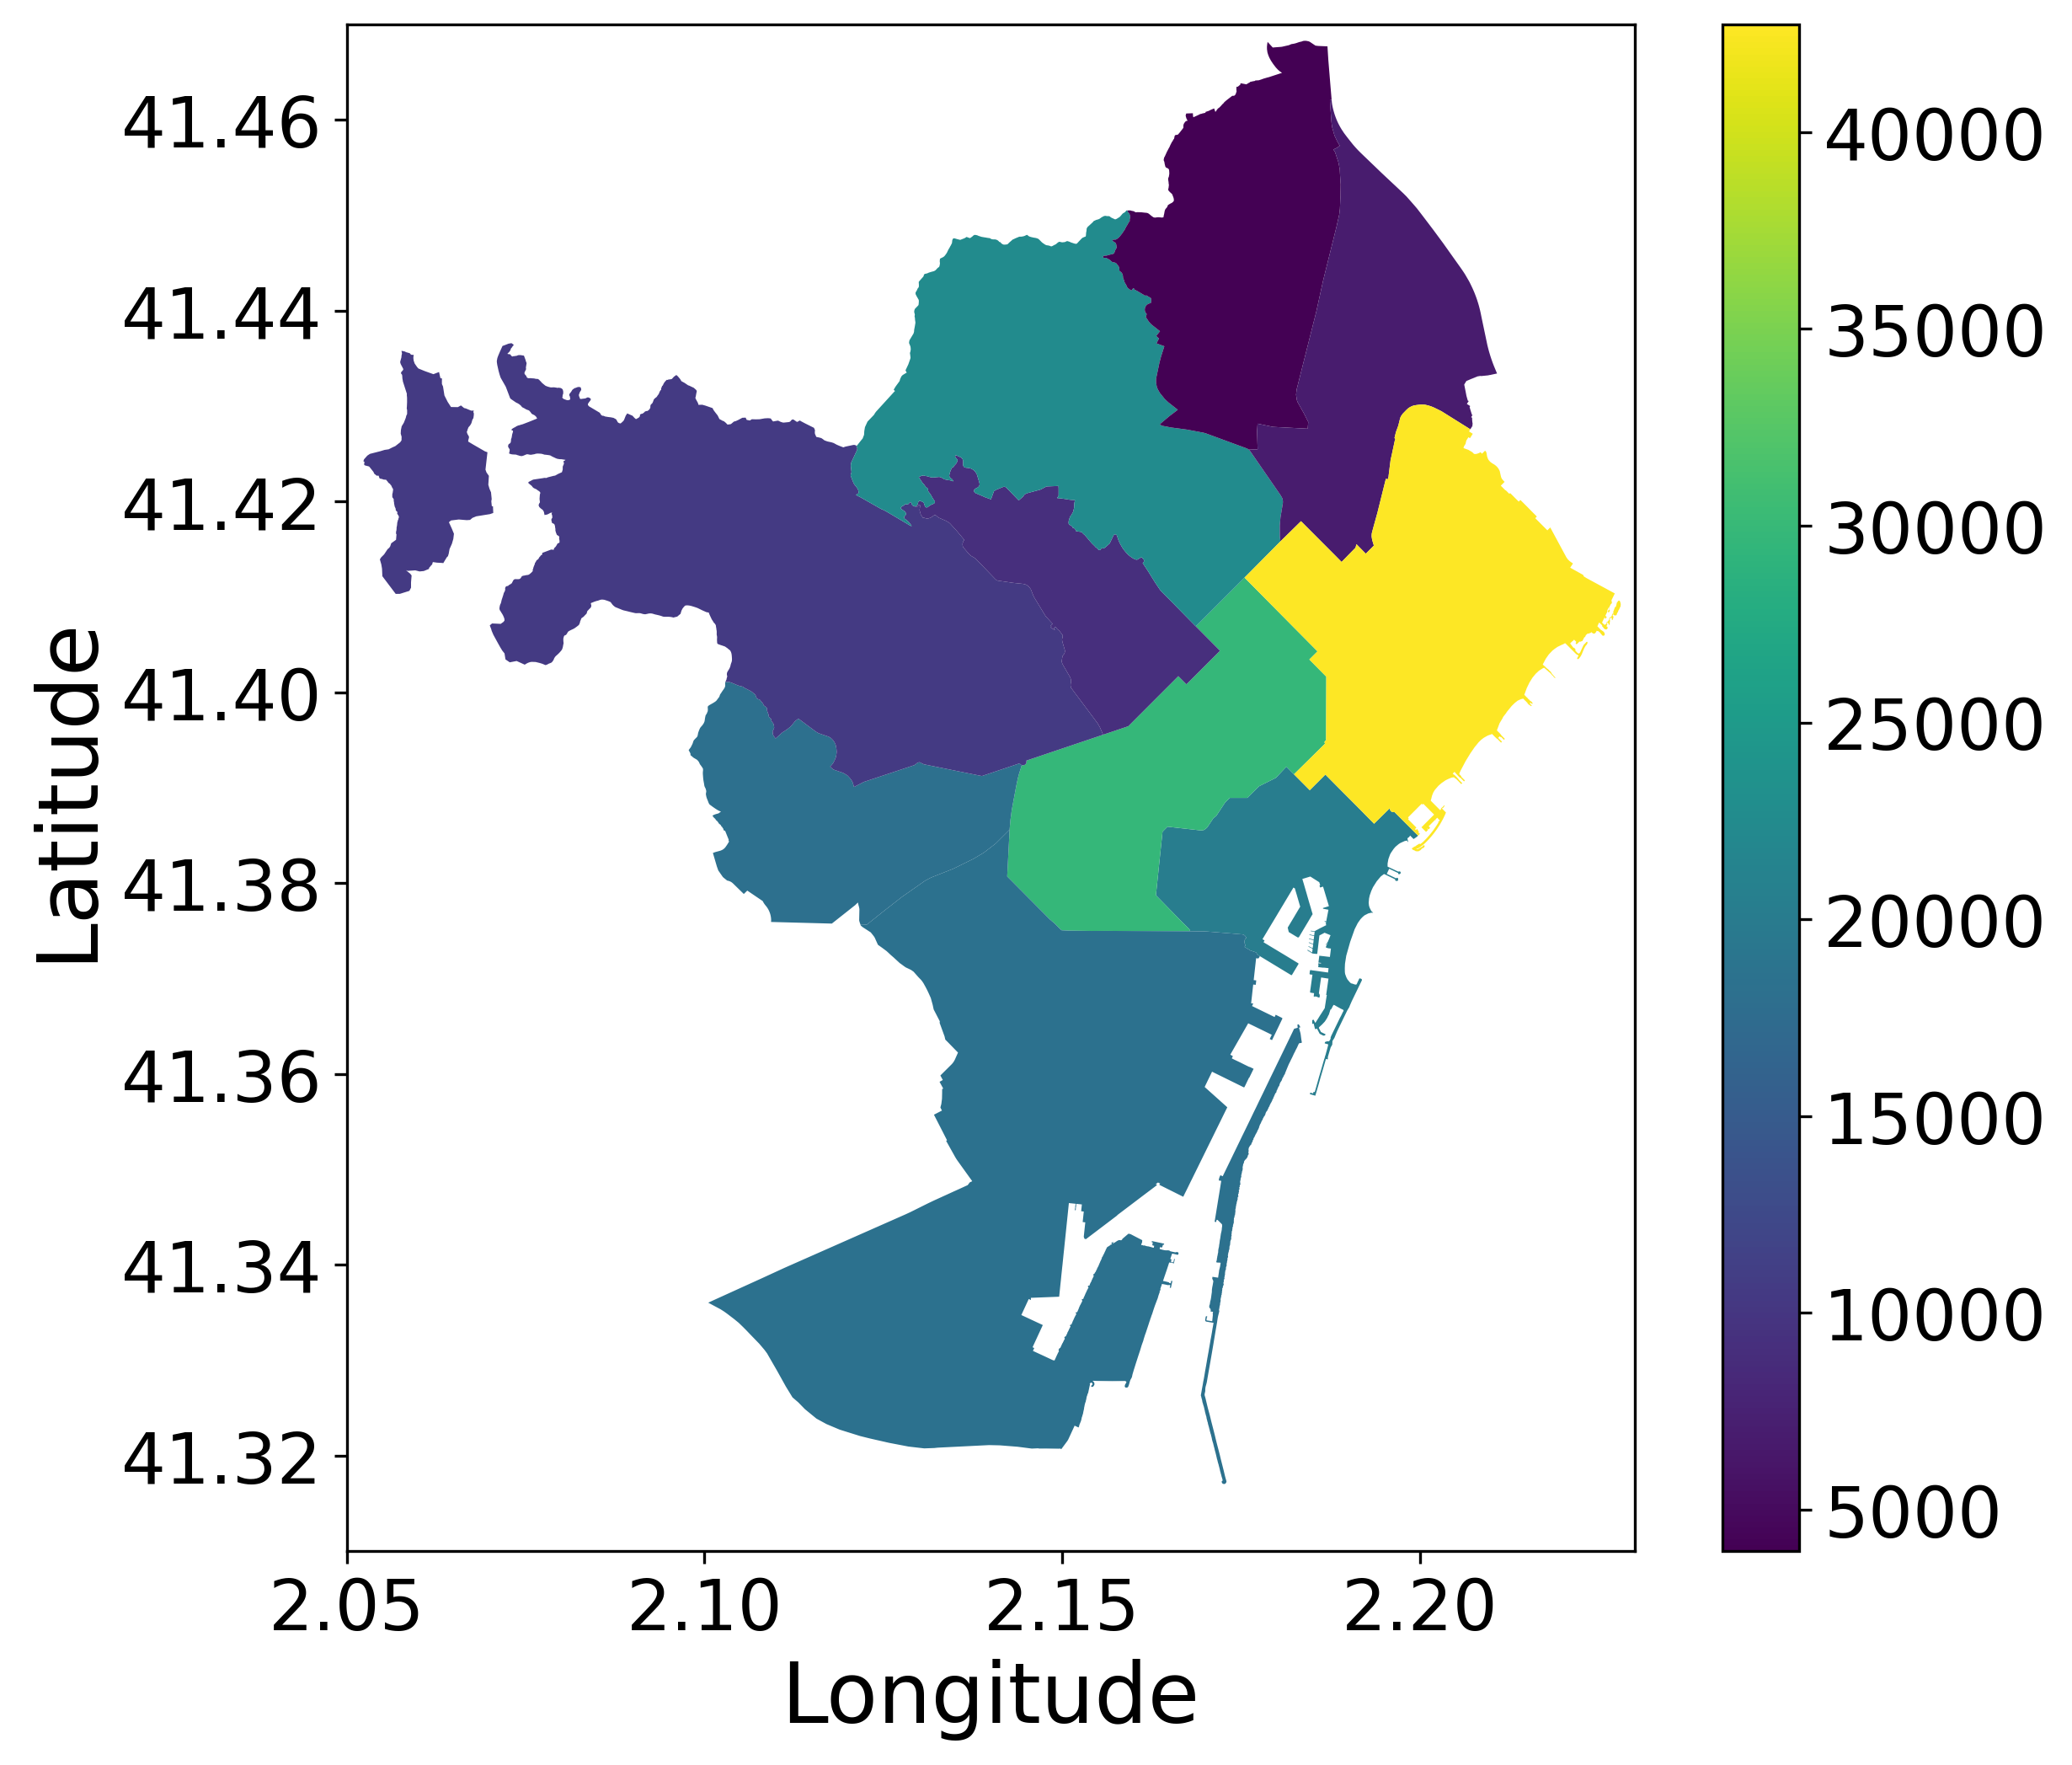

In [83]:
plt.rcParams.update({'font.size':20})
plt.rcParams['figure.dpi'] = 300
fig = df_districts.plot(column='counts', legend=True, figsize=(9,8))
plt.ylabel('Latitude', fontsize=24)
plt.xlabel('Longitude', fontsize=24)
plt.xlim(2.05,2.23)
plt.ylim(41.31,41.47)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#plt.show()
plt.savefig('img/mapillary_districts.png')
#plt.close()

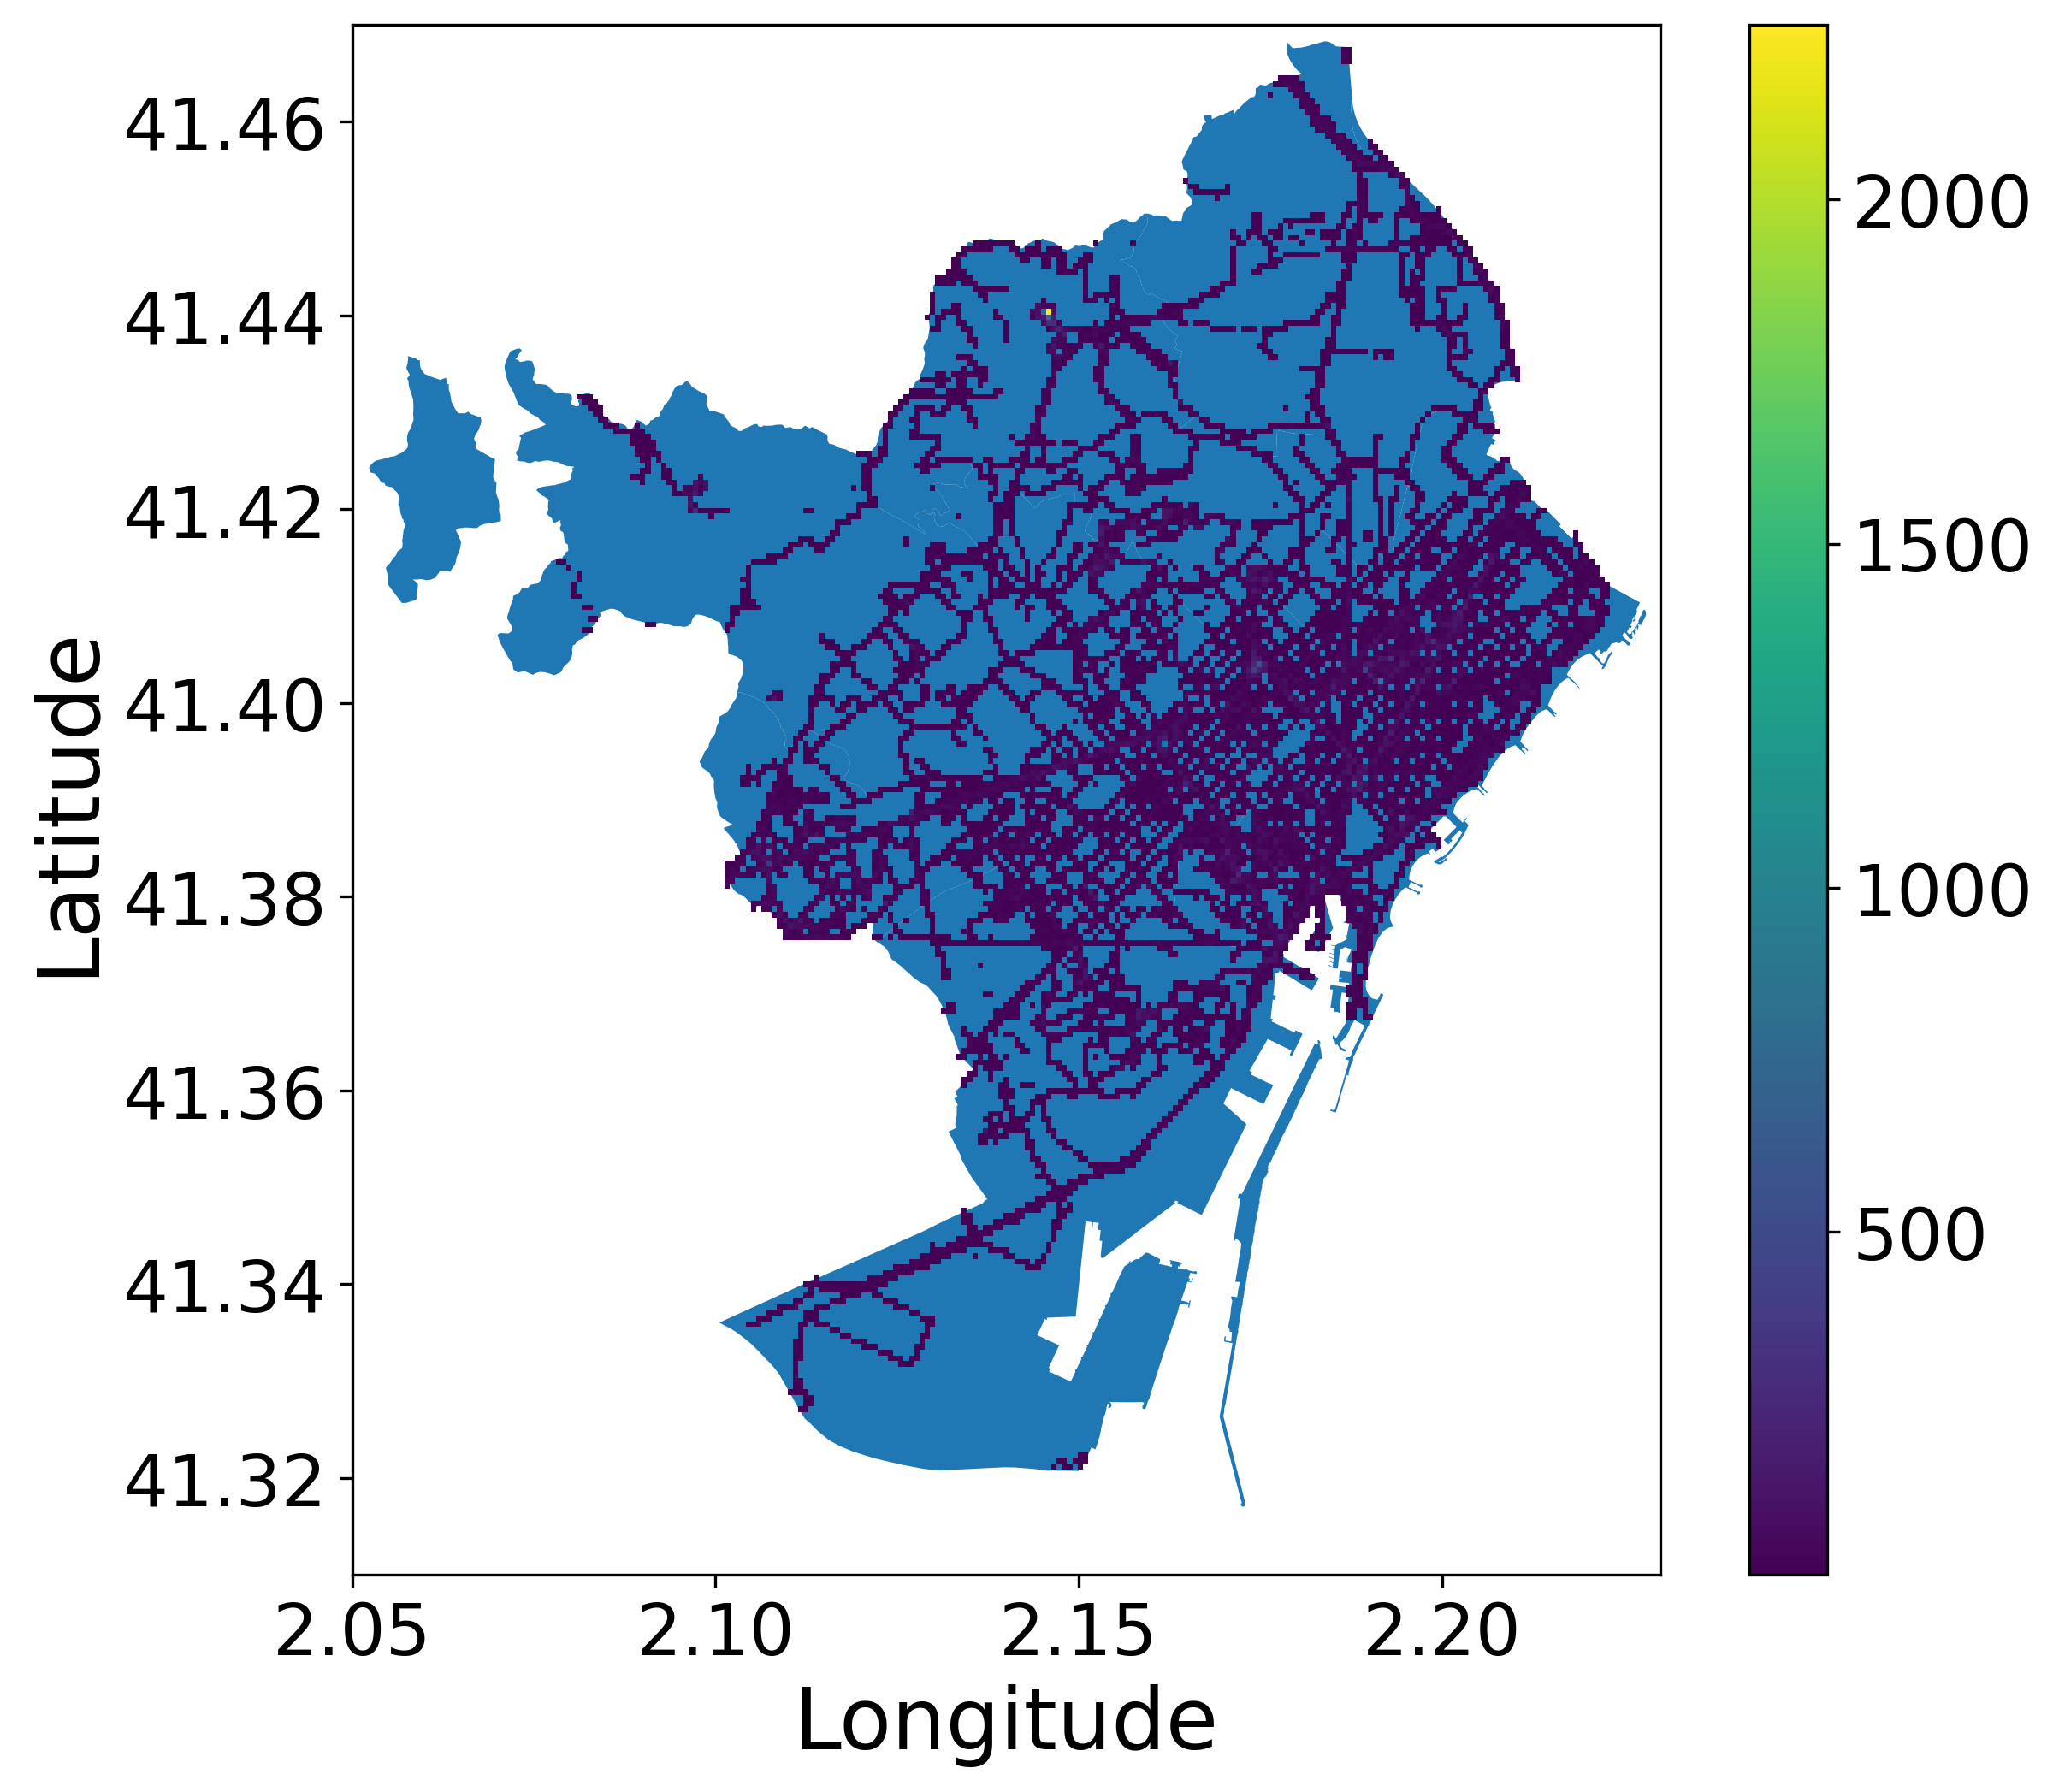

In [82]:
plt.rcParams.update({'font.size':20})
plt.rcParams['figure.dpi'] = 300
fig = df_districts['geometry'].plot(figsize=(9,8))
plt.hist2d(df['long'],df['lat'], bins=(200,250), cmin=1)#, cmap='viridis')
plt.colorbar()
plt.ylabel('Latitude', fontsize=24)
plt.xlabel('Longitude', fontsize=24)
plt.xlim(2.05,2.23)
plt.ylim(41.31,41.47)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig('img/mapillary_heatmap.png')
# plt.show()
# plt.close()